# compare_accuracy.ipynb
This notebook is used to compare the accuracy and simulation times as various parameters are varied.
First, a reference network is simulated with high precision. This high precision comes from:
1. Cubic spline interpolation for the buffer values.
2. A relatively large minimum buffer size = 40.
3. Use of the `odeint` solver with `rtol` = 1e-5, `atol` = 1e-5.
4. A small `min_delay` (minimum delay) value (0.001).

Each of these four factors will be altered individually. For each variation, the maximum difference in the unit activities with respect to the high-precision simulation will be reported, along with simulation time. In addition, variations for factors 2 and 3 will be run for flat networks.

## initial setup for the reference network
Before running this simulation, the code in `units.py` was modified so that the `unit.get_act` method had the contents:

    return self.interpolator(time)
    
Moreover, in `unit.__init__` there should be a line:

    self.using_interp1d = True
    
Configuration of `interp1d` is in `unit.upd_interpolator`, and was set as:
    
    self.interpolator = interp1d(self.times, self.buffer, kind='cubic',
                                 bounds_error=False, copy=False,
                                 fill_value="extrapolate", assume_sorted=True)
                                
The simulated network consists of an excitatory and an inhibitory population, called `e` and `i` respectively. Each population consists of 50 sigmoidal units, arranged in a 5x10 grid. Connections are made randomly, so that each excitatory unit sends projections to 10 other excitatory units (with delay 0.2), and to 15 inhibitory units (with delay 0.5). Each inhibitory unit sends projections to 10 excitatory units with delay 0.5.

The simulation starts from random initial parameters, and lasts for 10 seconds. After 5 seconds a step-like input is provided half of the excitatory units, and this input is maintained until the end of the simulation.

In [1]:
from ei_net import *
import pickle
from scipy.interpolate import interp1d

In [2]:
def create_ref_net():
    """ Returns an ei_net with parameter dictionaries for the high-accuracy configuration. """
    ei = ei_net()
    # network dictionary
    ei.set_param('net_params', 'min_delay', 0.001)
    ei.set_param('net_params', 'min_buff_size', 40)
    ei.set_param('net_params', 'rtol', 1e-5)
    ei.set_param('net_params', 'atol', 1e-5)
    # geometry dictionaries
    ei.set_param('e_geom', 'rows', 5)
    ei.set_param('e_geom', 'columns', 10)
    ei.set_param('e_geom', 'jitter', 0.)
    ei.set_param('i_geom', 'rows', 5)
    ei.set_param('i_geom', 'columns', 10)
    ei.set_param('i_geom', 'jitter', 0.)
    ei.set_param('n', 'w_track', 5)
    # connection dictionaries
    ei.set_param('ee_conn', 'mask', {'circular': {'radius' : 5.}}) # large mask
    ei.set_param('ee_conn', 'kernel', 1.) # deterministic kernel
    ei.set_param('ee_conn', 'number_of_connections', 10)
    ei.set_param('ee_conn', 'delays', {'linear': {'c': 0.2, 'a':0.}})
    ei.set_param('ee_conn', 'weights', {'uniform': {'low': 0.5, 'high':0.5}})
        
    ei.set_param('ei_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('ei_conn', 'kernel', 1.)
    ei.set_param('ei_conn', 'number_of_connections', 15)
    ei.set_param('ei_conn', 'delays', {'linear': {'c': 0.5, 'a':0.}})
    ei.set_param('ei_conn', 'weights', {'uniform': {'low': 0.2, 'high':0.2}})
        
    ei.set_param('ie_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('ie_conn', 'kernel', 1.)
    ei.set_param('ie_conn', 'number_of_connections', 10)
    ei.set_param('ie_conn', 'delays', {'linear': {'c': 0.5, 'a':0.}})
    ei.set_param('ie_conn', 'weights', {'uniform': {'low': -0.4, 'high':-0.4}})
        
    ei.set_param('xe_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('xe_conn', 'kernel', 1.)
    ei.set_param('xe_conn', 'number_of_connections', 25)
    ei.set_param('xe_conn', 'delays', {'linear': {'c': 0.1, 'a':0.}})
    ei.set_param('xe_conn', 'weights', {'uniform': {'low': 1., 'high':1.}})
        
    ei.set_param('ii_conn', 'number_of_connections', 0)
    ei.set_param('xi_conn', 'number_of_connections', 0)
        
    return ei
    

In [3]:
# here is one object to run the comparisons
class comparator():
    def __init__(self):
        self.ei = create_ref_net()
        
    def build(self):
        self.ei.build()
    
    def run(self, n_pres=4, pres_time=1., flat_run=False):
        def inp_pat(pres, rows, columns):
            return np.ones(rows*columns) if pres >= 2 else np.zeros(rows*columns)
        self.ei.run(n_pres, pres_time, set_inp_pat=inp_pat, flat=flat_run)
        
    def compare(self, file_name='ref_data.pkl'):
        """ Compare with the reference simulation. """
        # load the data for the reference simulation
        opened_file = open(file_name, 'rb')
        read_times, read_activs = pickle.load(opened_file)
        opened_file.close()
        # index used to isolate the activities of e and i populations
        ei_idx = np.array(self.ei.e + self.ei.i)
        read_activs = read_activs[ei_idx]
        # use interpolation to set the activities at the same time points
        if len(self.ei.all_times) <= len(read_times): # the ref sim has more points
            ref_sol = interp1d(read_times, read_activs, axis=1)
            times = self.ei.all_times
            ref_activs = ref_sol(times)
            comp_activs = self.ei.all_activs[ei_idx]
        else:
            comp_sol = interp1d(self.ei.all_times, self.ei.all_activs[ei_idx], axis=1)
            times = read_times
            comp_activs = comp_sol(times)
            ref_activs = read_activs

        diff = ref_activs - comp_activs
        self.max_diff = np.amax(np.abs(diff))
        self.mean_diff = np.mean(np.abs(diff))
        print("Maximum difference in all values: %f " % (self.max_diff))
        print("Mean difference for all values: %f" %(self.mean_diff))
        
        # Plotting the activity of the units with the maximum difference
        unit, tpoint = np.unravel_index([np.argmax(np.abs(diff))], diff.shape)
        fig = plt.figure(figsize=(20,10))
        plt.plot(times, comp_activs[unit[0]], 'b')
        plt.plot(times, ref_activs[unit[0]], 'r')

In [4]:
# Create and build the ei_net object
ref_net = comparator()
ref_net.build()
ref_net.run()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 244.50405192375183 seconds.
Presentation 1 took 283.0539445877075 seconds.
Presentation 2 took 257.9824285507202 seconds.
Presentation 3 took 259.44726300239563 seconds.
Total execution time is 1044.9900887012482 seconds


In [5]:
# Save the simlation data for the reference network
ref_data_file = open('ref_data.pkl', 'wb')
pickle.dump((ref_net.ei.all_times, ref_net.ei.all_activs), ref_data_file)
ref_data_file.close()

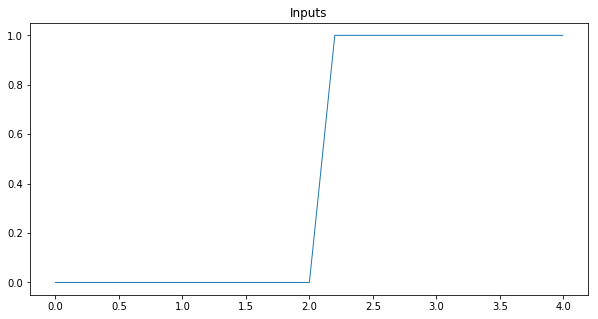

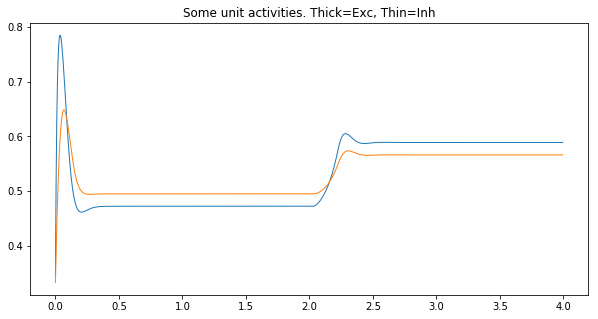

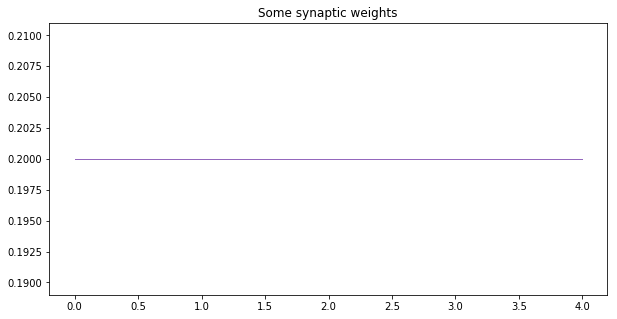

In [7]:
ref_net.ei.basic_plot()

In [9]:
#%matplotlib qt5
ref_net.ei.act_anim(ref_net.ei.e, 0.6, slider=False)

## Comparator class

## Variation 1: change interpolation method
**Variation 1a**: use `interp1d` with linear interpolation. All that is required is to change `kind` from `cubic` to `linear` in the `unit.upd_interpolator` method.

--- 

**Variation 1b**: use draculab's own linear interpolator.
In `unit.__init__` the variable `using_interp1d` was set to `False`, and in `unit.get_act` the content was:

    return cython_get_act3(time, self.times[0], self.time_bit, self.buff_size, self.buffer)
    
Before each variation, make sure to reset the kernel and run the first 3 cells.

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 55.84676146507263 seconds.
Presentation 1 took 43.34933090209961 seconds.
Presentation 2 took 36.05111217498779 seconds.
Presentation 3 took 43.644700050354004 seconds.
Total execution time is 178.8929660320282 seconds
Maximum difference in all values: 0.000091 
Mean difference for all values: 0.000001


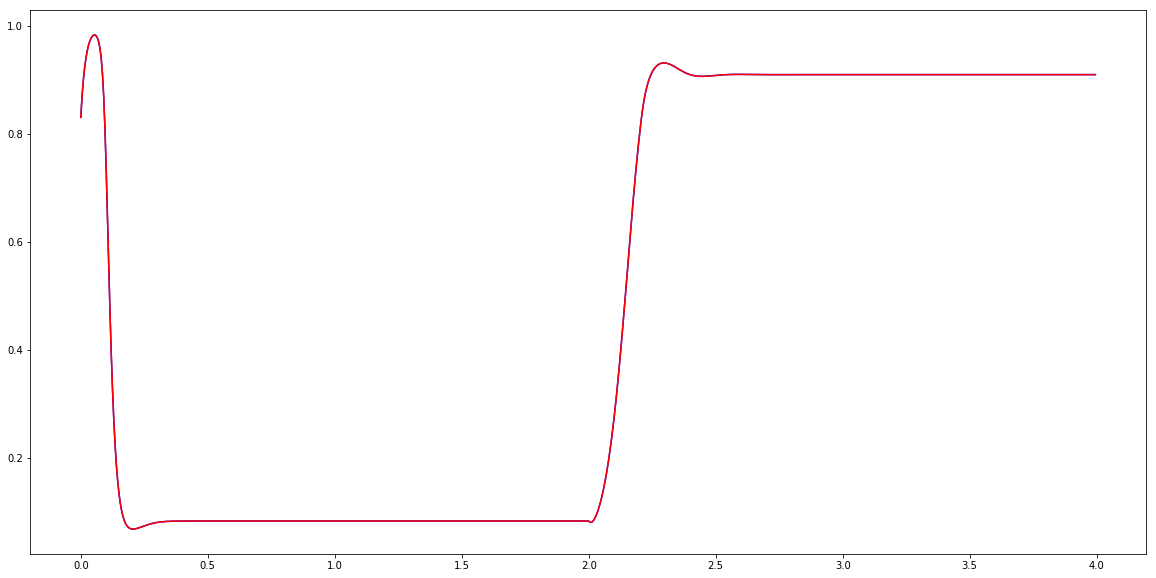

In [4]:
# these variations don't require chnages to the comparator object
var1a = comparator()
var1a.build()
var1a.run()
var1a.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 3.7991652488708496 seconds.
Presentation 1 took 3.819918394088745 seconds.
Presentation 2 took 3.608292818069458 seconds.
Presentation 3 took 3.769009590148926 seconds.
Total execution time is 14.997355937957764 seconds
Maximum difference in all values: 0.015439 
Mean difference for all values: 0.000068


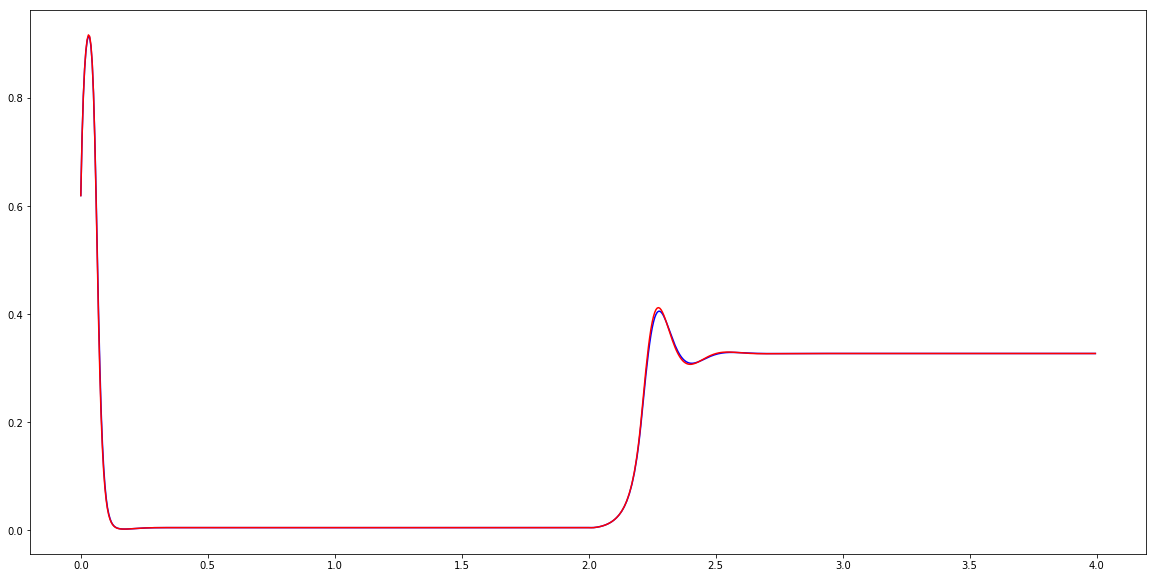

In [4]:
var1b = comparator()
var1b.build()
var1b.run()
var1b.compare()

## Variation 2: change the minimum buffer size
Interpolation was set back to cubic splines, as in the reference network.

**Variation 2a**: set `min_buff_size = 20`

**Variation 2b**: set `min_buff_size = 5`

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 45.06971788406372 seconds.
Presentation 1 took 44.325138092041016 seconds.


/home/z/projects/draculab/units.py:1110: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-self.slope*(arg - self.thresh)))


Presentation 2 took 41.2087345123291 seconds.
Presentation 3 took 44.480520725250244 seconds.
Total execution time is 175.0851767063141 seconds
Maximum difference in all values: 0.000104 
Mean difference for all values: 0.000001


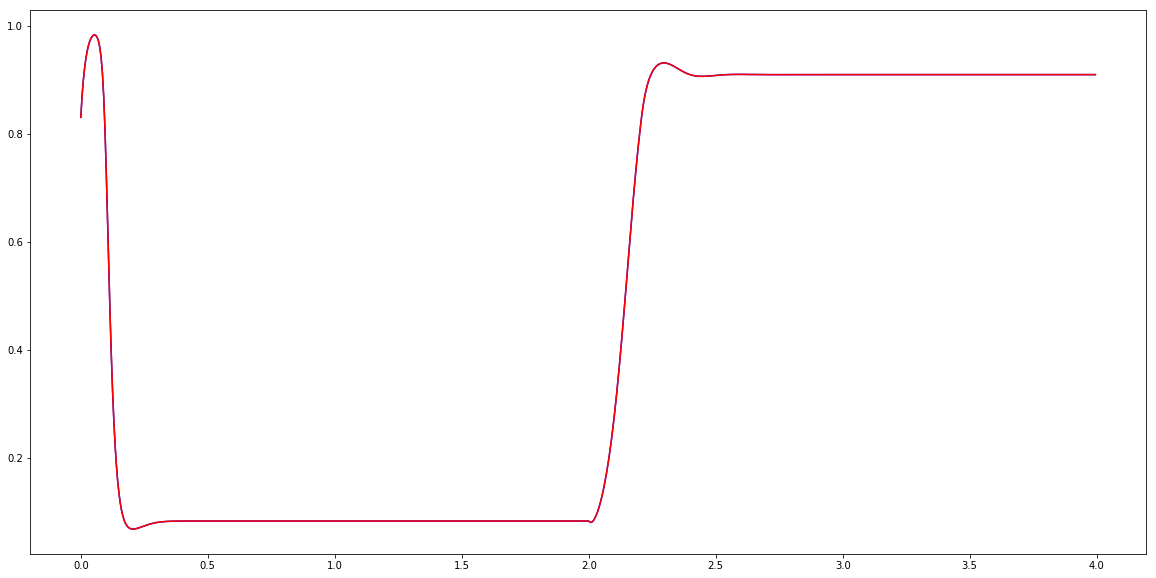

In [4]:
var2a = comparator()
var2a.ei.set_param('net_params', 'min_buff_size', 20)
var2a.build()
var2a.run()
var2a.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 42.93629455566406 seconds.


/home/z/projects/draculab/units.py:1110: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-self.slope*(arg - self.thresh)))


Presentation 1 took 42.67665076255798 seconds.
Presentation 2 took 42.24422240257263 seconds.
Presentation 3 took 52.913583755493164 seconds.
Total execution time is 180.77159214019775 seconds
Maximum difference in all values: 0.000483 
Mean difference for all values: 0.000008


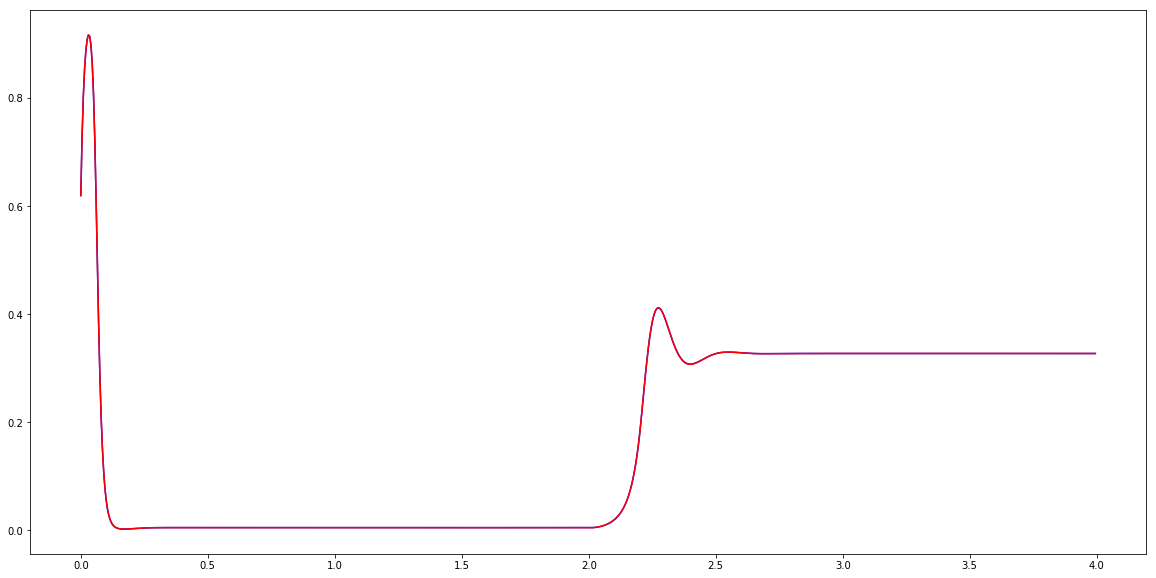

In [5]:
var2b = comparator()
var2b.ei.set_param('net_params', 'min_buff_size', 5)
var2b.build()
var2b.run()
var2b.compare()

## Variation 3: change the tolerances of the `odeint` integrator

**Variation 3a**: set them to 1e-3

**Variation 3b**: set them to 1e-1

**Variation 3c**: use the `euler` integration method.

**Variation 3d**: use the `euler` integration method, and draculab's linear interpolation.

**Variation 3e**: Use `euler` integration with a flat network.

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 41.27233600616455 seconds.
Presentation 1 took 41.567238092422485 seconds.
Presentation 2 took 41.00853729248047 seconds.
Presentation 3 took 41.92572593688965 seconds.
Total execution time is 165.77477884292603 seconds
Maximum difference in all values: 0.003741 
Mean difference for all values: 0.000037


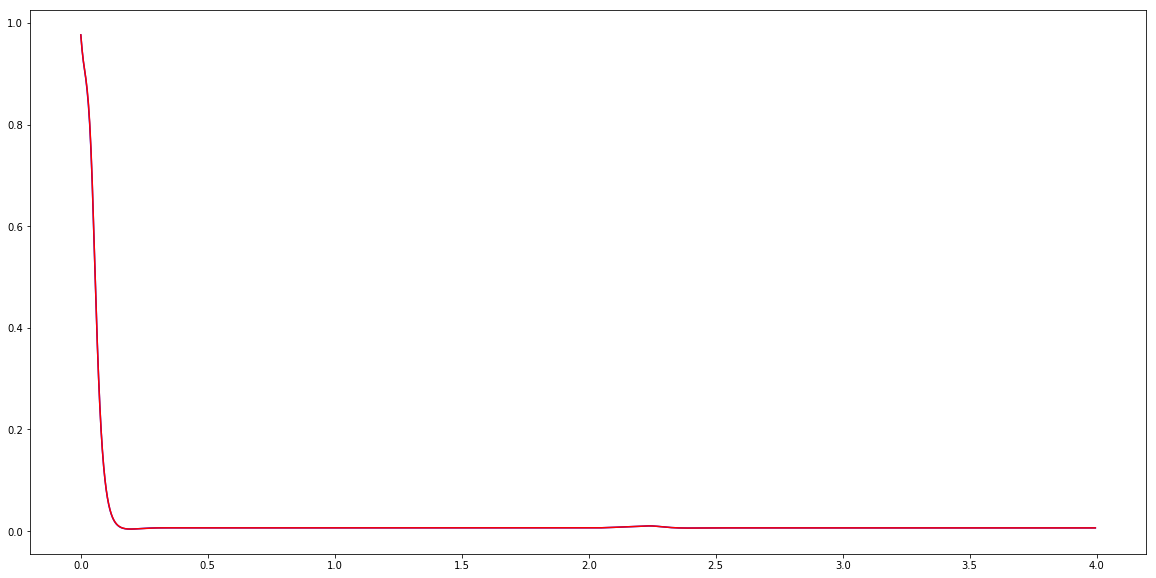

In [5]:
var3a = comparator()
var3a.ei.set_param('net_params', 'rtol', 1e-3)
var3a.ei.set_param('net_params', 'atol', 1e-3)
var3a.build()
var3a.run()
var3a.compare()

In [4]:
var3b = comparator()
var3b.ei.set_param('net_params', 'rtol', 0.1)
var3b.ei.set_param('net_params', 'atol', 0.1)
var3b.build()
var3b.run()
var3b.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 42.10821580886841 seconds.
Presentation 1 took 60.770806312561035 seconds.
Presentation 2 took 41.81154799461365 seconds.
Presentation 3 took 41.91551399230957 seconds.
Total execution time is 186.6072165966034 seconds


UnboundLocalError: local variable 'ref_values' referenced before assignment

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 203.533052444458 seconds.
Presentation 1 took 205.75456857681274 seconds.
Presentation 2 took 222.68228220939636 seconds.
Presentation 3 took 203.59154057502747 seconds.
Total execution time is 835.5624017715454 seconds
Maximum difference in all values: 0.001637 
Mean difference for all values: 0.000012


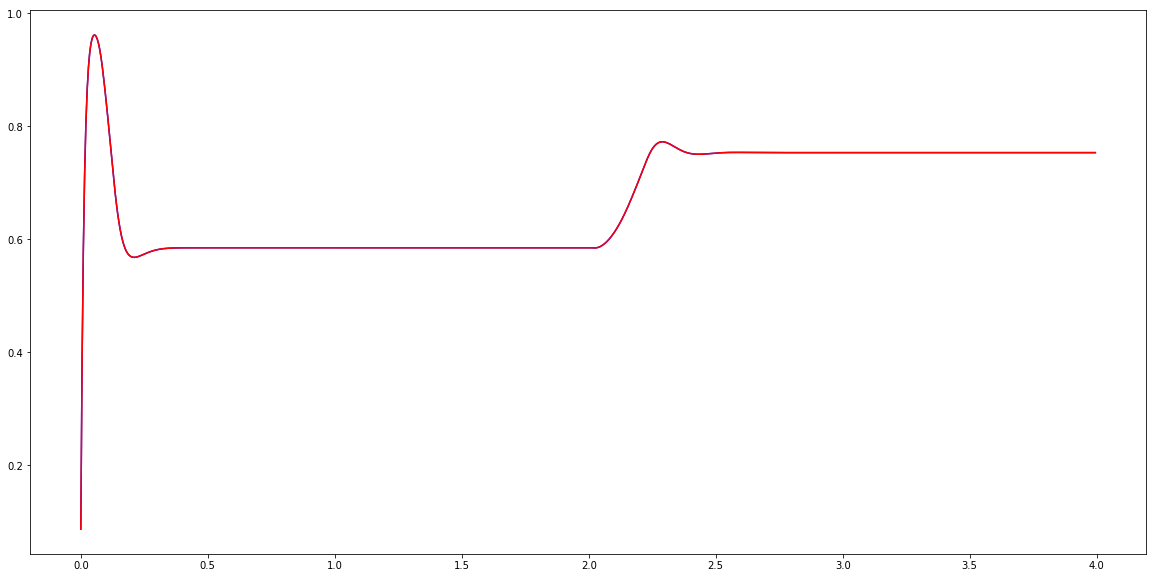

In [4]:
var3c = comparator()
var3c.ei.set_param('e_pars', 'integ_meth', 'euler')
var3c.ei.set_param('i_pars', 'integ_meth', 'euler')
var3c.build()
var3c.run()
var3c.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 13.775469303131104 seconds.
Presentation 1 took 13.7634437084198 seconds.
Presentation 2 took 13.748047113418579 seconds.
Presentation 3 took 13.759216070175171 seconds.
Total execution time is 55.047154903411865 seconds
Maximum difference in all values: 0.014383 
Mean difference for all values: 0.000051


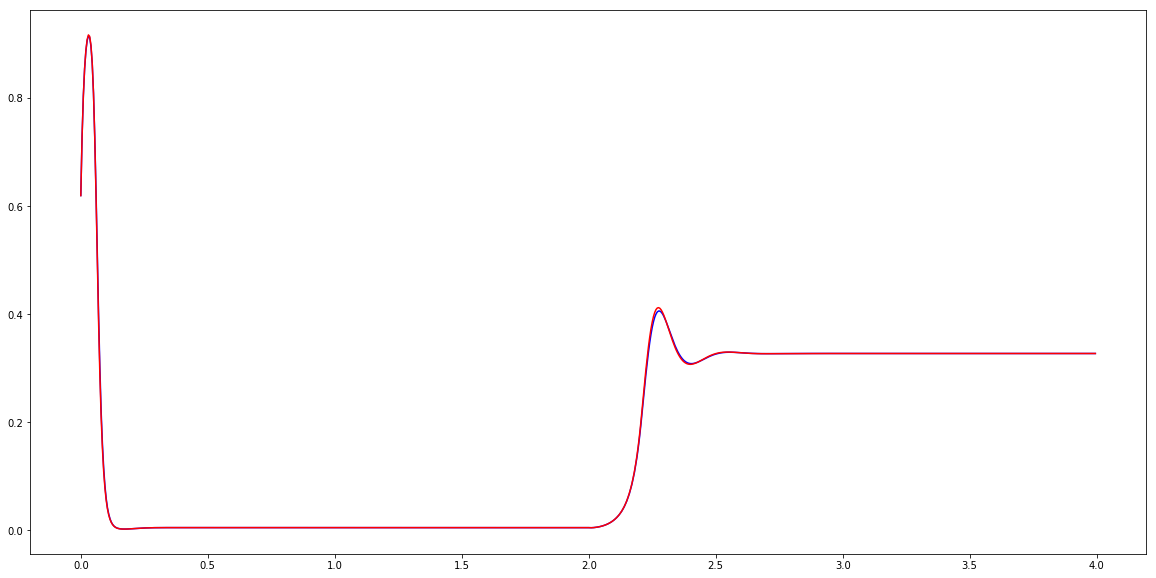

In [4]:
# the code in 'unit' was changed before running this
var3d = comparator()
var3d.ei.set_param('e_pars', 'integ_meth', 'euler')
var3d.ei.set_param('i_pars', 'integ_meth', 'euler')
var3d.build()
var3d.run()
var3d.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 2.5407421588897705 seconds.
Presentation 1 took 2.5221989154815674 seconds.
Presentation 2 took 2.5268394947052 seconds.
Presentation 3 took 2.5307364463806152 seconds.
Total execution time is 10.121306896209717 seconds
Maximum difference in all values: 0.004005 
Mean difference for all values: 0.000019


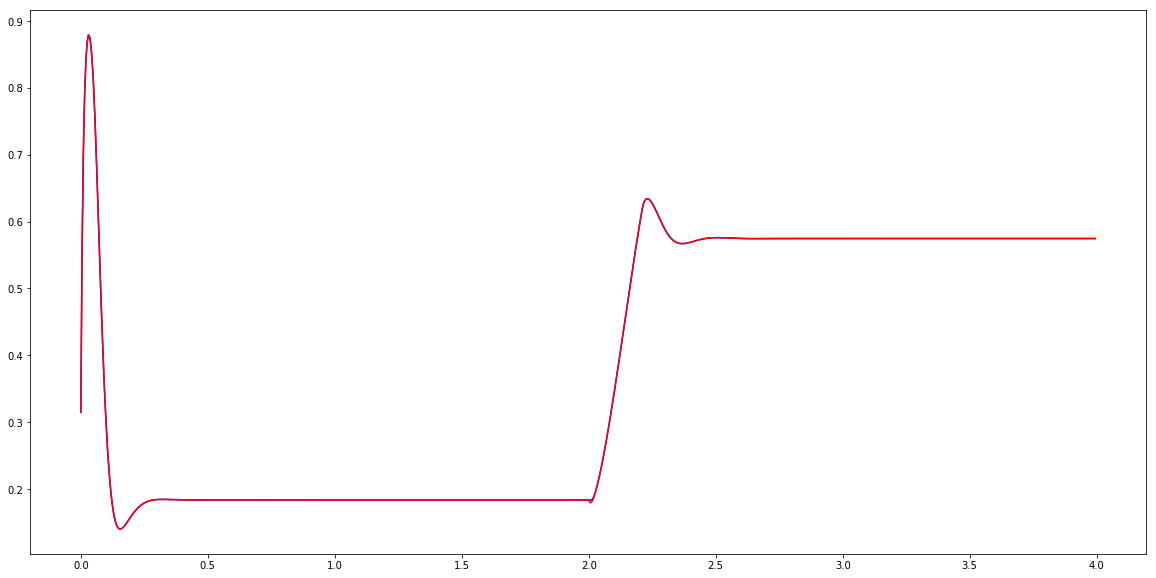

In [6]:
# the code in 'unit' was changed before running this
var3e = comparator()
var3e.ei.set_param('e_pars', 'integ_meth', 'euler')
var3e.ei.set_param('i_pars', 'integ_meth', 'euler')
var3e.build()
var3e.run(flat_run=True)
var3e.compare()

## Variation 4: Increase `min_delay`

**Variation 4a**: set `min_delay=0.02`

**Variation 4b**: set `min_delay=0.2`

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 15.349859952926636 seconds.
Presentation 1 took 12.640803813934326 seconds.


/home/z/projects/draculab/units.py:1110: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-self.slope*(arg - self.thresh)))


Presentation 2 took 14.41445517539978 seconds.
Presentation 3 took 33.62967228889465 seconds.
Total execution time is 76.03545141220093 seconds
Maximum difference in all values: 0.519283 
Mean difference for all values: 0.004028


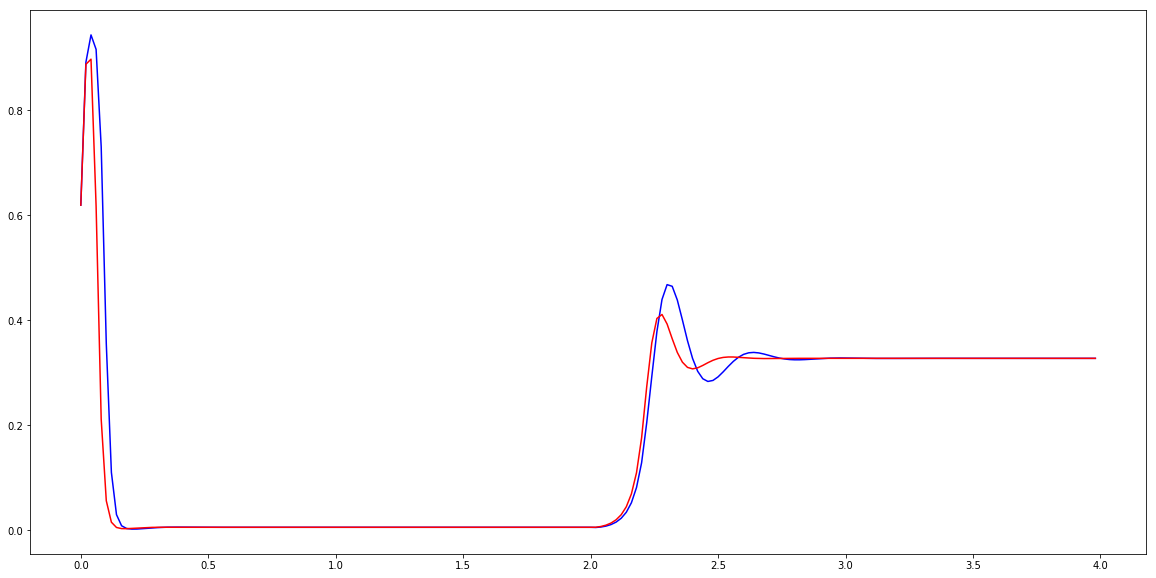

In [4]:
var4a = comparator()
var4a.ei.set_param('net_params', 'min_delay', 0.02)
var4a.build()
var4a.run()
var4a.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 7.263586521148682 seconds.
Presentation 1 took 4.477224826812744 seconds.
Presentation 2 took 5.908350944519043 seconds.
Presentation 3 took 4.4877142906188965 seconds.
Total execution time is 22.137595176696777 seconds
Maximum difference in all values: 0.982132 
Mean difference for all values: 0.076748


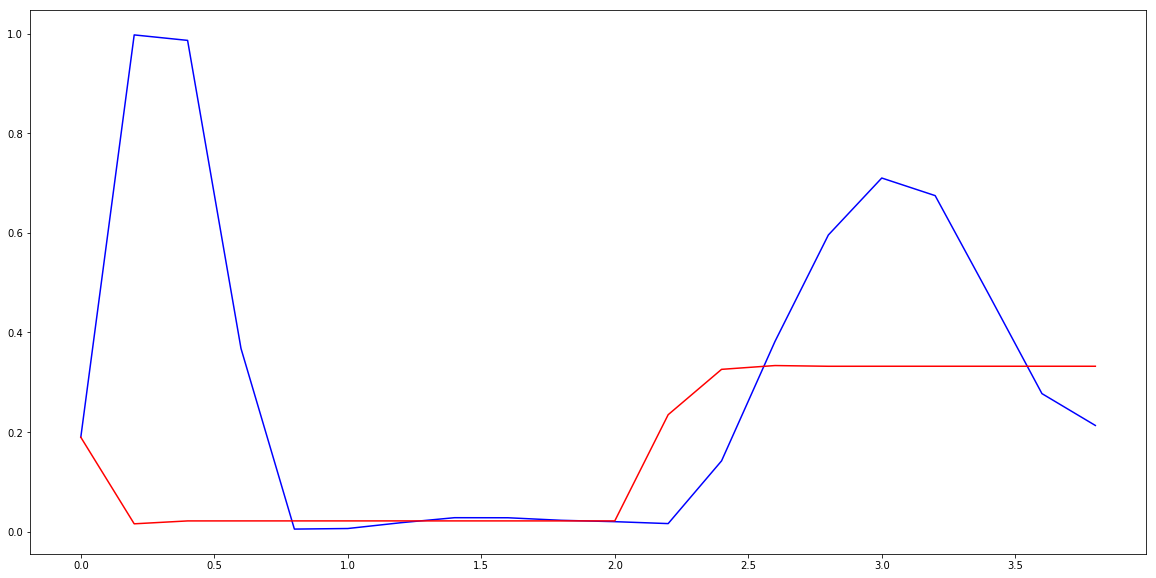

In [7]:
var4b = comparator()
var4b.ei.set_param('net_params', 'min_delay', 0.2)
var4b.build()
var4b.run()
var4b.compare()

## Variation 5: extra configurations

**Variation 5a**: Flat network using Euler integration and a very `min_delay` size can be both fast and accurate.

**Variation 5b**: Euler integration can become unstable when increasing `min_delay`.

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 138.0948348045349 seconds.
Presentation 1 took 155.41338324546814 seconds.
Presentation 2 took 136.9268639087677 seconds.
Presentation 3 took 137.4772539138794 seconds.
Total execution time is 567.9256291389465 seconds
Maximum difference in all values: 0.059718 
Mean difference for all values: 0.000301


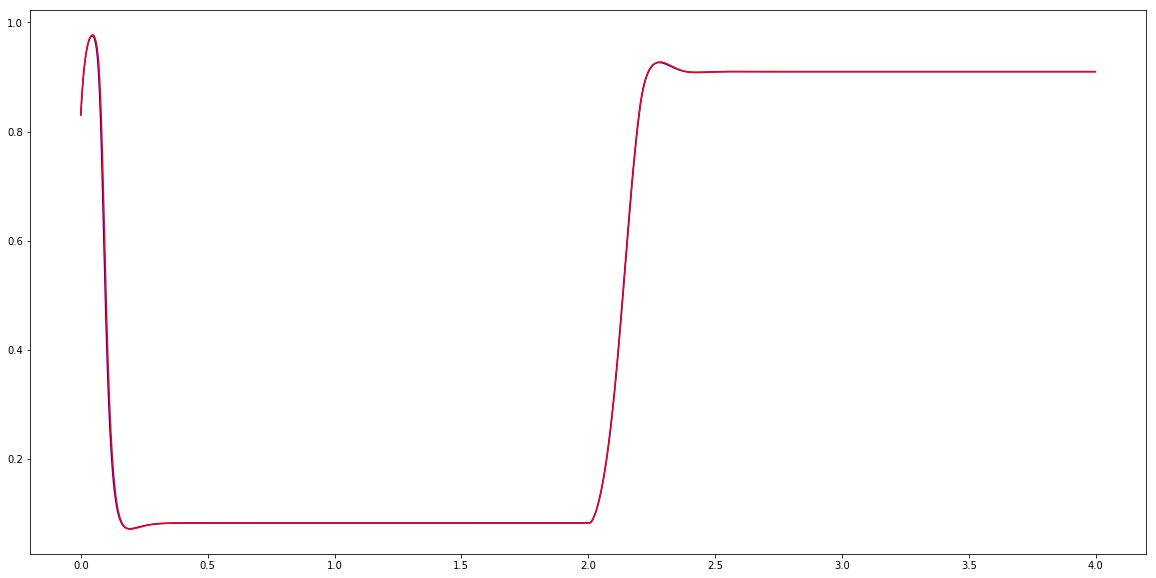

In [8]:
var5a = comparator()
var5a.ei.set_param('e_pars', 'integ_meth', 'euler')
var5a.ei.set_param('i_pars', 'integ_meth', 'euler')
var5a.ei.set_param('net_params', 'min_delay', 0.0001)
var5a.build()
var5a.run(flat_run=True)
var5a.compare()

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 104.60276675224304 seconds.
Presentation 1 took 104.74407243728638 seconds.
Presentation 2 took 121.4073314666748 seconds.
Presentation 3 took 104.92447328567505 seconds.
Total execution time is 435.6793067455292 seconds
Maximum difference in all values: 0.451643 
Mean difference for all values: 0.002705


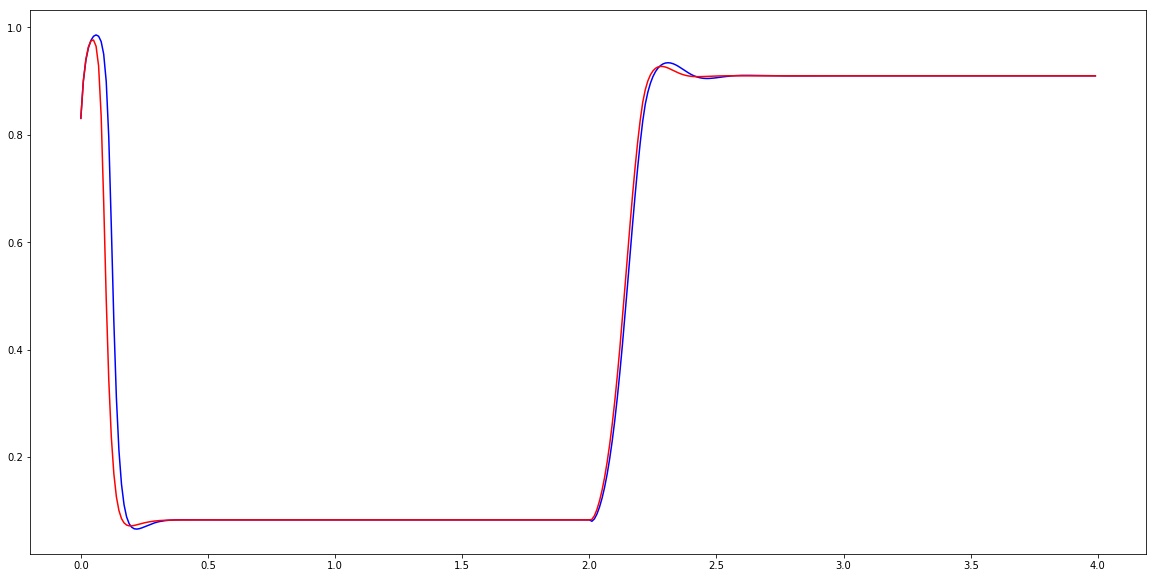

In [9]:
var5b = comparator()
var5b.ei.set_param('e_pars', 'integ_meth', 'euler')
var5b.ei.set_param('i_pars', 'integ_meth', 'euler')
var5b.ei.set_param('net_params', 'min_delay', 0.01)
var5b.build()
var5b.run()
var5b.compare()

In [8]:
simlog = []
simlog.append('Reference network has total simulation time of 190.0531768798828 seconds')
simlog.append('Variation 1a has a maximum difference of 0.000091')
simlog.append('Variation 1a has a mean difference of 0.000001')
simlog.append('Variation 1a has total execution time of 178.8929660320282 seconds')
simlog.append('Variation 1b has a maximum difference of 0.015439')
simlog.append('Variation 1b has a mean difference of 0.000068')
simlog.append('Variation 1b has total execution time of 14.997355937957764 seconds')

simlog.append('Variation 2a has a maximum difference of 0.000104')
simlog.append('Variation 2a has a mean difference of 0.000001')
simlog.append('Variation 2a has total execution time of 177.83505034446716 seconds')
simlog.append('Variation 2b has a maximum difference of 0.000483')
simlog.append('Variation 2b has a mean difference of 0.000008')
simlog.append('Variation 2b has total execution time of 180.77159214019775 seconds')

simlog.append('Variation 3a has a maximum difference of 0.003741')
simlog.append('Variation 3a has a mean difference of 0.000034')
simlog.append('Variation 3a has total execution time of 168.95755577087402 seconds')
simlog.append('Variation 3b has a maximum difference of 0.021991')
simlog.append('Variation 3b has a mean difference of 0.000089')
simlog.append('Variation 3b has total execution time of 165.59642910957336 seconds')

simlog.append('Variation 3c has a maximum difference of 0.001637 ')
simlog.append('Variation 3c has a mean difference of 0.000012')
simlog.append('Variation 3c has total execution time of 835.5624017715454 seconds')
simlog.append('Variation 3d has a maximum difference of 0.014383')
simlog.append('Variation 3d has a mean difference of 0.000051')
simlog.append('Variation 3d has total execution time of 55.047154903411865 seconds')

simlog.append('Variation 3e has a maximum difference of 0.004005')
simlog.append('Variation 3e has a mean difference of 0.000019')
simlog.append('Variation 3e has total execution time of 10.121306896209717 seconds')

simlog.append('Variation 4a has a maximum difference of 76.03545141220093')
simlog.append('Variation 4a has a mean difference of 0.519283 ')
simlog.append('Variation 4a has total execution time of 0.004028 seconds')
simlog.append('Variation 4b has a maximum difference of 0.982132')
simlog.append('Variation 4b has a mean difference of 0.0.072404')
simlog.append('Variation 4b has total execution time of 22.515557289123535 seconds')

simlog.append('Variation 5a has a maximum difference of ')
simlog.append('Variation 5a has a mean difference of ')
simlog.append('Variation 5a has total execution time of seconds')


In [10]:
simlog

['Reference network has total simulation time of 190.0531768798828 seconds',
 'Variation 1a has a maximum difference of 0.000091',
 'Variation 1a has a mean difference of 0.000001',
 'Variation 1a has total execution time of 178.8929660320282 seconds',
 'Variation 1b has a maximum difference of 0.015439',
 'Variation 1b has a mean difference of 0.000068',
 'Variation 1b has total execution time of 14.997355937957764 seconds',
 'Variation 2a has a maximum difference of 0.000104',
 'Variation 2a has a mean difference of 0.000001',
 'Variation 2a has total execution time of 177.83505034446716 seconds',
 'Variation 2b has a maximum difference of 0.000483',
 'Variation 2b has a mean difference of 0.000008',
 'Variation 2b has total execution time of 180.77159214019775 seconds',
 'Variation 3a has a maximum difference of 0.003741',
 'Variation 3a has a mean difference of 0.000034',
 'Variation 3a has total execution time of 168.95755577087402 seconds',
 'Variation 3b has a maximum difference